In [1]:
%matplotlib inline

from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


random forest models modified. changed criterion to absolute error

In [2]:
def add_t_minus(df, n):
    if n == 0:
        return df
    df_res = df.copy()
    for i in range(1,n+1):
        df_shifted = df.shift(i)
        diff = df - df_shifted.interpolate(method='spline', limit_direction='backward', order=1)
        diff = diff.drop('weekofyear', axis=1)
        for cname in diff.columns:
            diff.rename(columns = {cname:cname+'_'+str(i)}, inplace = True)

        df_res = df_res.join(diff)
    return df_res

def sj_preprocess_data(features, labels=None, tminus=0):
    pruned = ['weekofyear', 'ndvi_nw', 'ndvi_se', 'reanalysis_dew_point_temp_k',
       'reanalysis_specific_humidity_g_per_kg']
    if labels is not None:
        features = features.join(labels)

    #features['month'] = features['week_start_date'].dt.month
    
    
    features.reset_index(inplace=True)
    features.set_index('week_start_date',inplace=True)
    features = features.drop('year', axis=1)

    #features = features.drop('weekofyear', axis=1)

    features = features.interpolate(method="spline", order=1)
    
    if labels is not None:
        #nfeatures = add_t_minus(features.drop('total_cases', axis=1), tminus)
        nfeatures = add_t_minus(features[pruned], tminus)
        return nfeatures, features['total_cases']
    else:
        return add_t_minus(features[pruned], tminus)


def iq_preprocess_data(features, labels=None, tminus=0):
    pruned = ['weekofyear', 'ndvi_nw', 'ndvi_sw', 'reanalysis_air_temp_k',
       'reanalysis_dew_point_temp_k', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c',
       'station_min_temp_c', 'station_precip_mm']

    if labels is not None:
        features = features.join(labels)

    #features['month'] = features['week_start_date'].dt.month
    
    
    features.reset_index(inplace=True)
    features.set_index('week_start_date',inplace=True)
    features = features.drop('year', axis=1)

    #features = features.drop('weekofyear', axis=1)

    features = features.interpolate(method="spline", order=1)
    
    if labels is not None:
        #nfeatures = add_t_minus(features.drop('total_cases', axis=1), tminus)
        nfeatures = add_t_minus(features[pruned], tminus)
        return nfeatures, features['total_cases']
    else:
        return add_t_minus(features[pruned], tminus)



def get_data(features_path, labels_path=None, sj_tminus=0, iq_tminus=0):
    if labels_path is not None:
        labels = pd.read_csv(labels_path,
                           index_col=[0,1,2])

    features = pd.read_csv(features_path,
                             index_col=[0,1,2],
                             parse_dates=['week_start_date'])

    # Separate data for San Juan
    sj_features = features.loc['sj']
    if labels_path is not None:
        sj_labels = labels.loc['sj']

    # Separate data for Iquitos
    iq_features = features.loc['iq']
    if labels_path is not None:
        iq_labels = labels.loc['iq']

    if labels_path is not None:
        sj_f, sj_l = sj_preprocess_data(sj_features, sj_labels, sj_tminus)
        iq_f, iq_l = iq_preprocess_data(iq_features, iq_labels, iq_tminus)
        return sj_f, sj_l, iq_f, iq_l

    return sj_preprocess_data(sj_features, None, sj_tminus), iq_preprocess_data(iq_features, None, iq_tminus)


In [3]:
sj_tminus = 1
iq_tminus = 1
sj_X_train, sj_y_train, iq_X_train, iq_y_train = get_data('dengue_features_train.csv',
                                                        'dengue_labels_train.csv',
                                                        sj_tminus=sj_tminus,
                                                        iq_tminus=iq_tminus,
                                                        )

In [4]:
sj_X_train - sj_X_train.shift(6).interpolate(method='spline', limit_direction='backward', order=1)

,weekofyear,ndvi_nw,ndvi_se,reanalysis_dew_point_temp_k,reanalysis_specific_humidity_g_per_kg,ndvi_nw_1,ndvi_se_1,reanalysis_dew_point_temp_k_1,reanalysis_specific_humidity_g_per_kg_1
week_start_date,,,,,,,,,
1990-04-30,6.157648,-0.045519,0.019491,-2.438880,-2.184941,-0.044867,0.019342,-2.556953,-2.529083
1990-05-07,6.147624,-0.006898,-0.016632,-0.976745,-0.906553,0.038336,-0.036267,1.530061,1.353654
1990-05-14,6.137600,0.024064,-0.021787,0.431105,0.487549,0.030678,-0.005297,1.475796,1.469389
1990-05-21,6.127576,0.096334,0.048573,0.231813,0.230223,0.071987,0.070217,-0.131325,-0.182020
1990-05-28,6.117552,0.113637,0.072218,0.668234,0.685753,0.017022,0.023504,0.504410,0.530857
...,...,...,...,...,...,...,...,...,...
2008-03-25,6.000000,0.023200,0.160271,-0.845714,-0.722857,-0.004450,0.291486,-1.514286,-1.234286
2008-04-01,6.000000,0.078233,-0.126686,0.101429,0.124286,0.055033,-0.286957,0.947143,0.847143
2008-04-08,6.000000,-0.068170,-0.073872,0.230000,0.217143,-0.146403,0.052814,0.128571,0.092857


# load the provided data
train_features = pd.read_csv('dengue_features_train.csv',
                             index_col=[0,1,2],
                             parse_dates=['week_start_date'])

train_labels = pd.read_csv('dengue_labels_train.csv',
                           index_col=[0,1,2])

# Separate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

sj_X_train, sj_y_train = preprocess_data(sj_train_features,sj_train_labels)

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

iq_X_train, iq_y_train = preprocess_data(iq_train_features,iq_train_labels)

In [5]:
#split data in train and test
sj_X_train, sj_X_test, sj_y_train, sj_y_test = train_test_split(
    sj_X_train, sj_y_train, test_size=0.3, shuffle=False)


iq_X_train, iq_X_test, iq_y_train, iq_y_test = train_test_split(
iq_X_train, iq_y_train, test_size=0.3, shuffle=False)

#remove everythin before 2002, it doesnt seem to have any value
iq_X_train = iq_X_train.loc['2002-01-01':]
iq_y_train = iq_y_train.loc['2002-01-01':]


In [6]:
sj_X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
weekofyear,655.0,26.810687,14.858483,1.000000,14.000000,27.000000,40.000000,53.000000
ndvi_nw,655.0,0.096682,0.078717,-0.130950,0.050250,0.090200,0.134000,0.437100
ndvi_se,655.0,0.181044,0.054837,0.036000,0.146207,0.178579,0.212529,0.393129
reanalysis_dew_point_temp_k,655.0,295.067408,1.566198,289.642857,293.840714,295.447143,296.355714,297.467143
reanalysis_specific_humidity_g_per_kg,655.0,16.508540,1.547369,11.715714,15.237143,16.837143,17.805714,19.044286
ndvi_nw_1,655.0,-0.000284,0.085765,-0.362975,-0.045833,-0.000170,0.050225,0.327467
ndvi_se_1,655.0,0.000150,0.069418,-0.215257,-0.047606,-0.000003,0.044925,0.265691
reanalysis_dew_point_temp_k_1,655.0,0.001723,0.832599,-3.727143,-0.382857,0.010000,0.367143,3.590000
reanalysis_specific_humidity_g_per_kg_1,655.0,0.001488,0.790592,-3.575714,-0.394286,0.015714,0.372143,3.224286


In [7]:
iq_X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
weekofyear,286.0,25.321678,14.994315,1.000000,12.250000,24.000000,38.000000,53.000000
ndvi_nw,286.0,0.232114,0.075149,0.072986,0.174711,0.224271,0.284818,0.428771
ndvi_sw,286.0,0.260263,0.081016,0.064743,0.205636,0.258582,0.315911,0.493443
reanalysis_air_temp_k,286.0,297.842963,1.097544,294.635714,297.162500,297.807857,298.459286,301.175714
reanalysis_dew_point_temp_k,286.0,295.519940,1.404300,290.088571,294.573571,295.975714,296.575357,297.852857
reanalysis_precip_amt_kg_per_m2,286.0,54.558408,49.941984,0.100000,23.397500,42.925000,66.245000,362.030000
reanalysis_specific_humidity_g_per_kg,286.0,17.121352,1.426131,12.111429,16.079286,17.544286,18.212500,19.731429
reanalysis_tdtr_k,286.0,9.164627,2.410604,4.185714,7.371429,8.992857,10.942857,16.028571
station_avg_temp_c,286.0,27.592878,0.917537,21.400000,27.206250,27.650000,28.225000,30.800000
station_diur_temp_rng_c,286.0,10.279301,1.511783,5.200000,9.283978,10.166667,11.161828,15.800000


In [8]:
# compute the correlations
sj_correlations = sj_X_train.corr()
iq_correlations = iq_X_train.corr()

Text(0.5, 1.0, 'San Juan Variable Correlations')

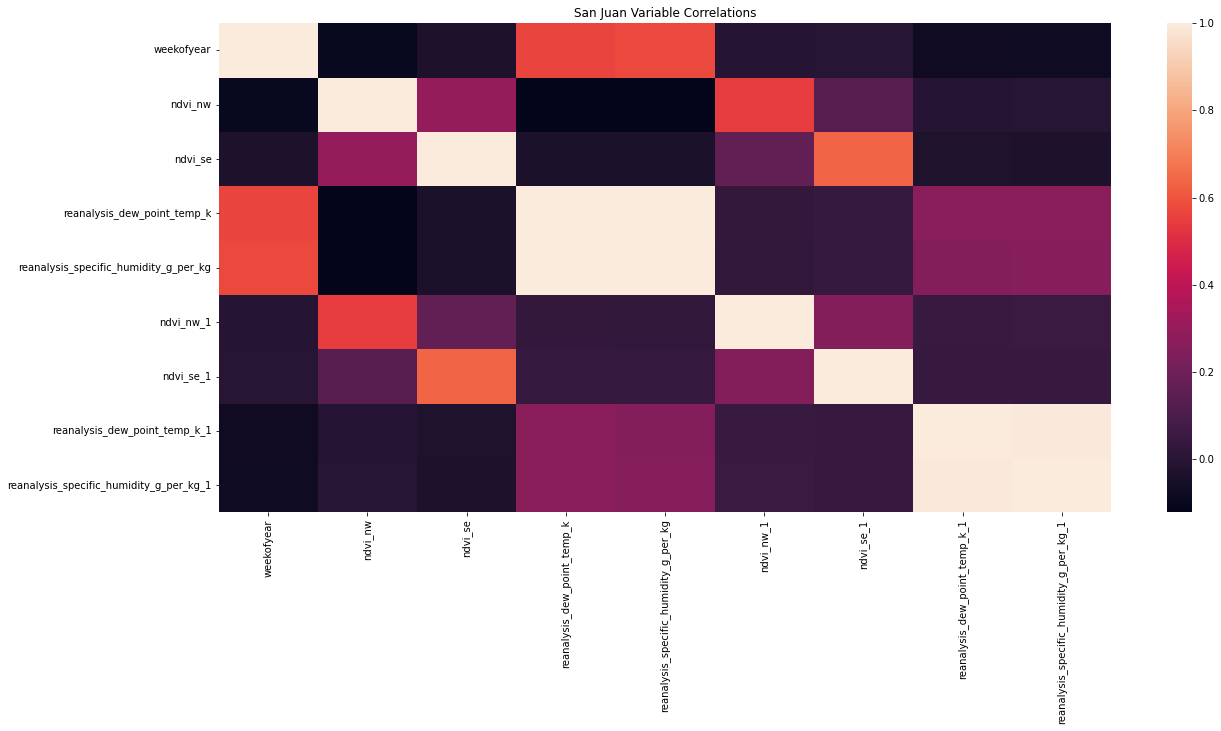

In [9]:
plt.rcParams["figure.figsize"] = (20,9)

# plot san juan
sj_corr_heat = sns.heatmap(sj_correlations)
plt.title('San Juan Variable Correlations')

In [10]:

#XGBRegressor(max_depth=5,learning_rate=.35,n_estimators=50,n_jobs=-1)
#sj_rf = XGBRegressor(max_depth=5,learning_rate=.05,n_estimators=100,n_jobs=-1)
sj_rf = XGBRegressor()                     
sj_rf.fit(sj_X_train, sj_y_train)
print(mean_absolute_error(sj_y_train, sj_rf.predict(sj_X_train)))
print(mean_absolute_error(sj_y_test, sj_rf.predict(sj_X_test)))

/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0.5583996567448587
23.751561047343596


/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [11]:
sj_rf.feature_importances_

array([0.14220709, 0.43322748, 0.12271019, 0.10487028, 0.05344635,
       0.06812599, 0.03355588, 0.02425629, 0.01760047], dtype=float32)

<AxesSubplot:ylabel='cols'>

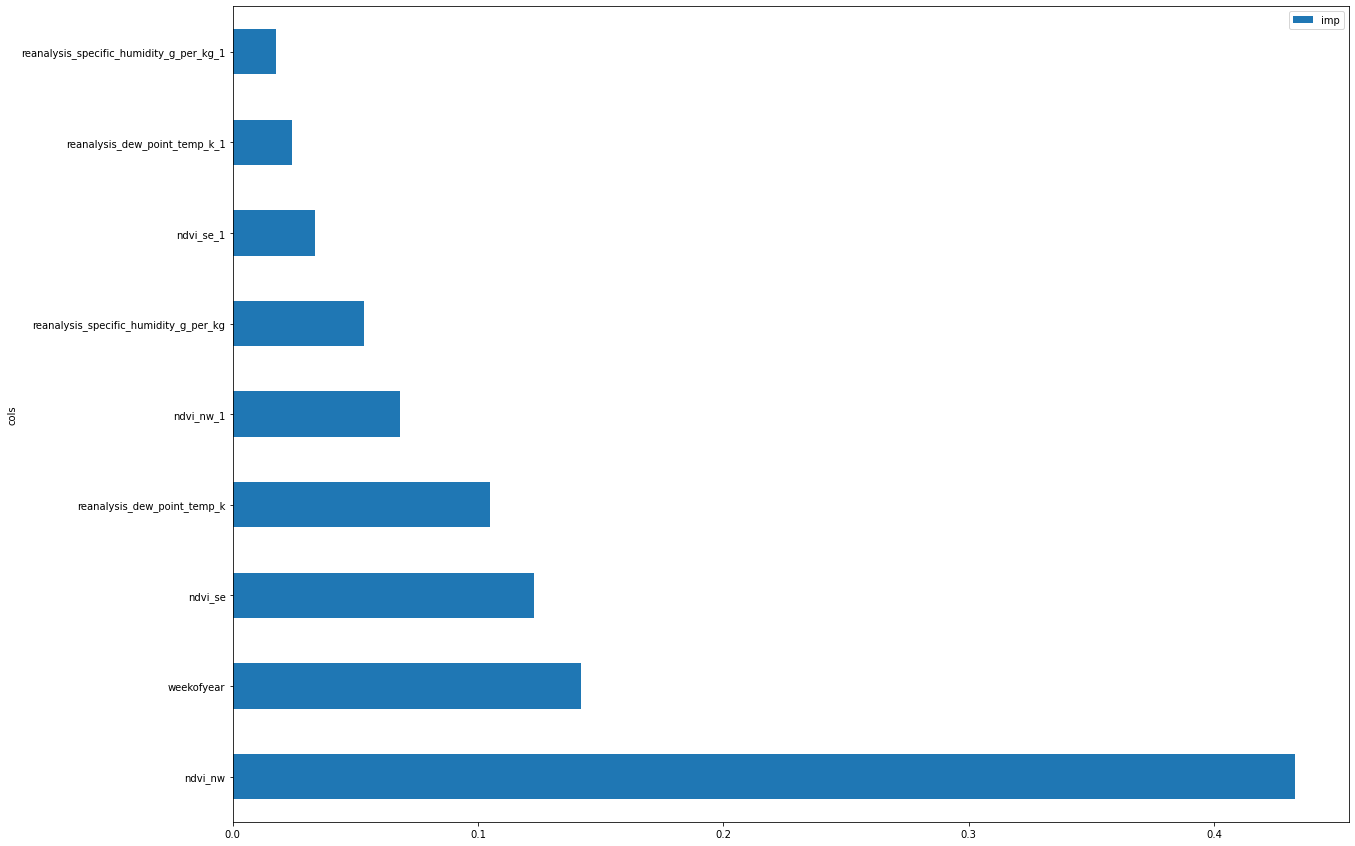

In [12]:
plt.rcParams["figure.figsize"] = (20,15)
(pd.DataFrame(dict(cols=sj_X_train.columns, imp=sj_rf.feature_importances_))
    .sort_values('imp', ascending=False)
    .plot('cols', 'imp', 'barh')
)

In [13]:
#iq_rf =  XGBRegressor(max_depth=5,learning_rate=.05,n_estimators=100,n_jobs=-1)
iq_rf =  XGBRegressor()
iq_rf.fit(iq_X_train, iq_y_train)
print(mean_absolute_error(iq_y_train, iq_rf.predict(iq_X_train)))
print(mean_absolute_error(iq_y_test, iq_rf.predict(iq_X_test)))

/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0.002057413299286321
8.029831529427797


/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [14]:
iq_rf.feature_importances_

array([0.08486851, 0.02352365, 0.02253041, 0.03033463, 0.0214674 ,
       0.06032482, 0.0592338 , 0.0695474 , 0.03932107, 0.03375414,
       0.04446567, 0.0117699 , 0.00865685, 0.02389302, 0.0099406 ,
       0.04867407, 0.01062484, 0.00988894, 0.30795273, 0.02107725,
       0.01025188, 0.0236733 , 0.02422515], dtype=float32)

<AxesSubplot:ylabel='cols'>

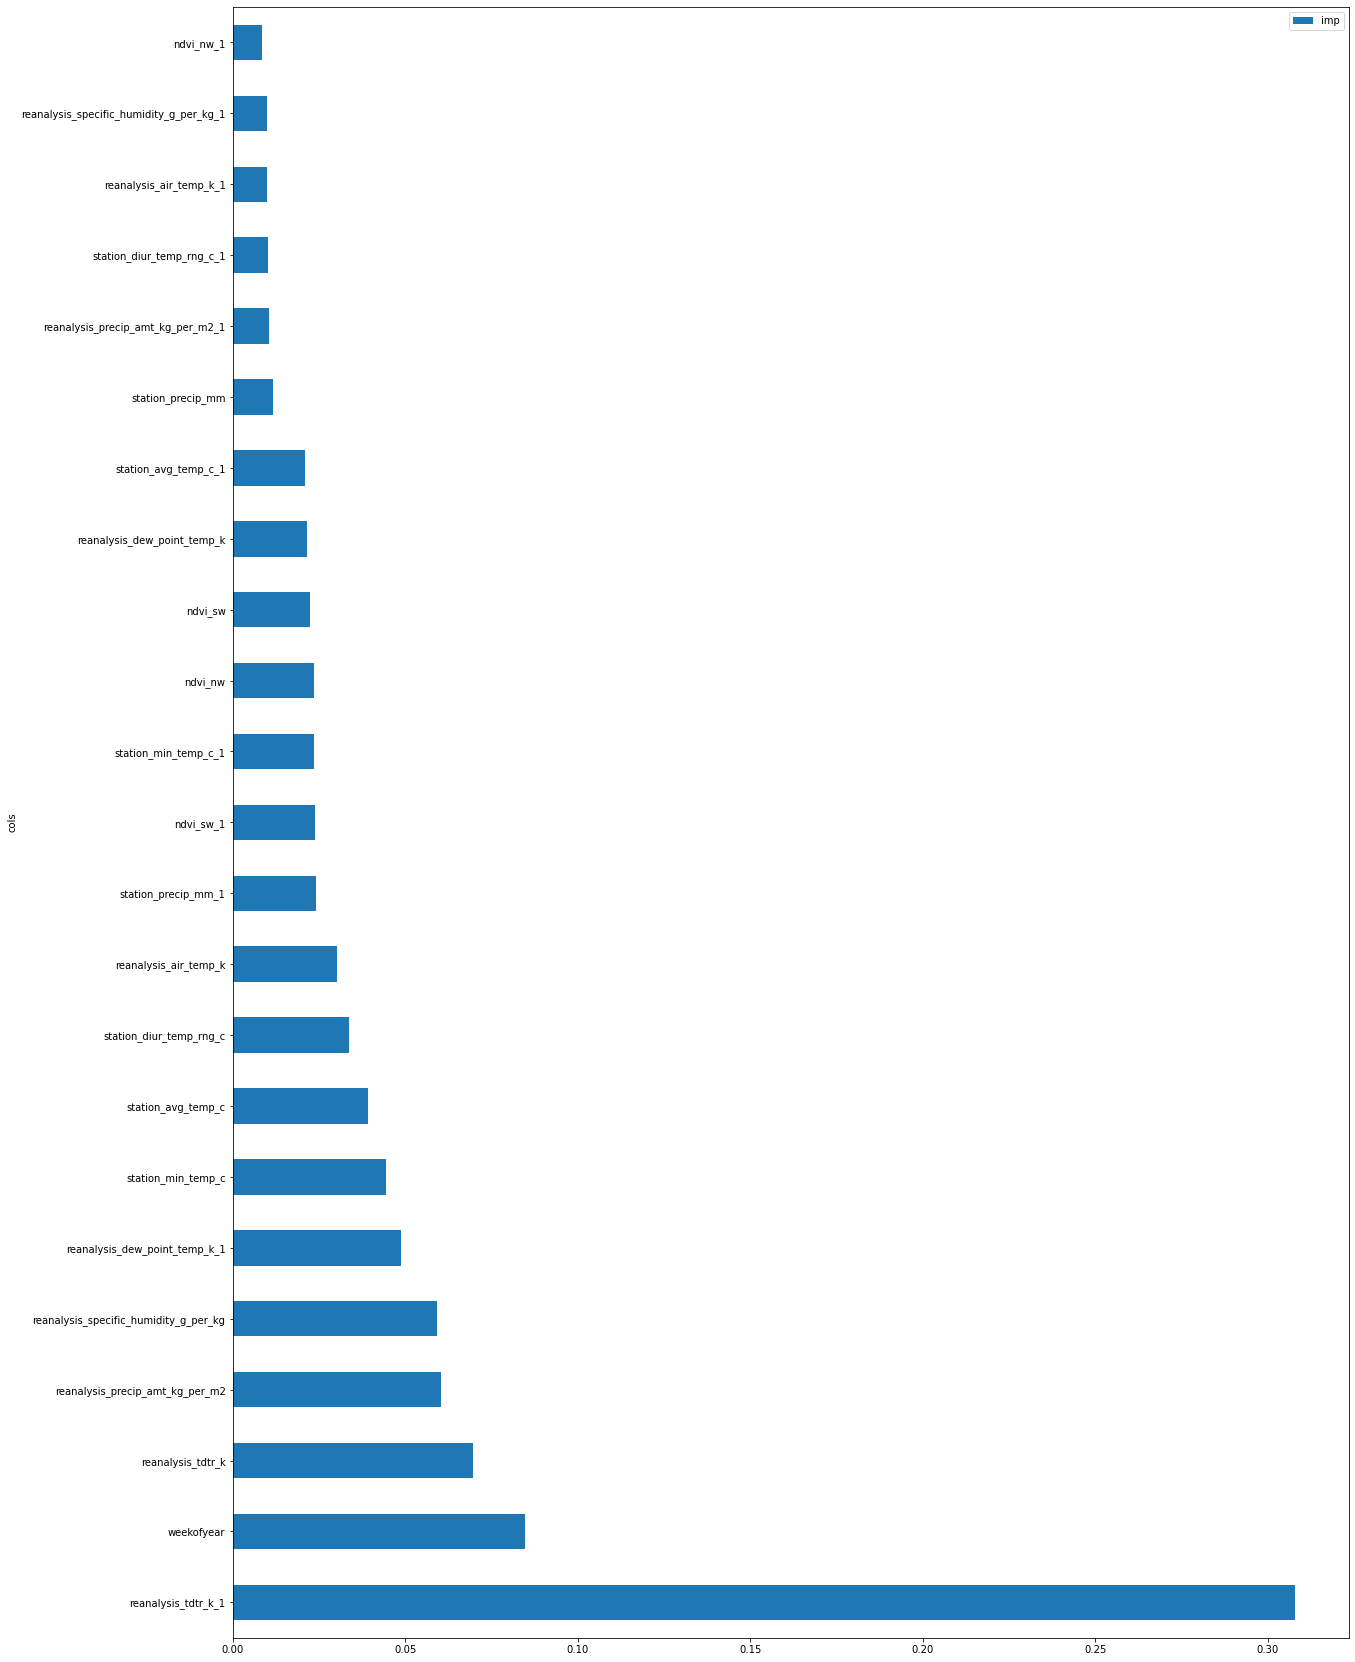

In [15]:
plt.rcParams["figure.figsize"] = (20,30)
(pd.DataFrame(dict(cols=iq_X_train.columns, imp=iq_rf.feature_importances_))
    .sort_values('imp', ascending=False)
    .plot('cols', 'imp', 'barh')
)

/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


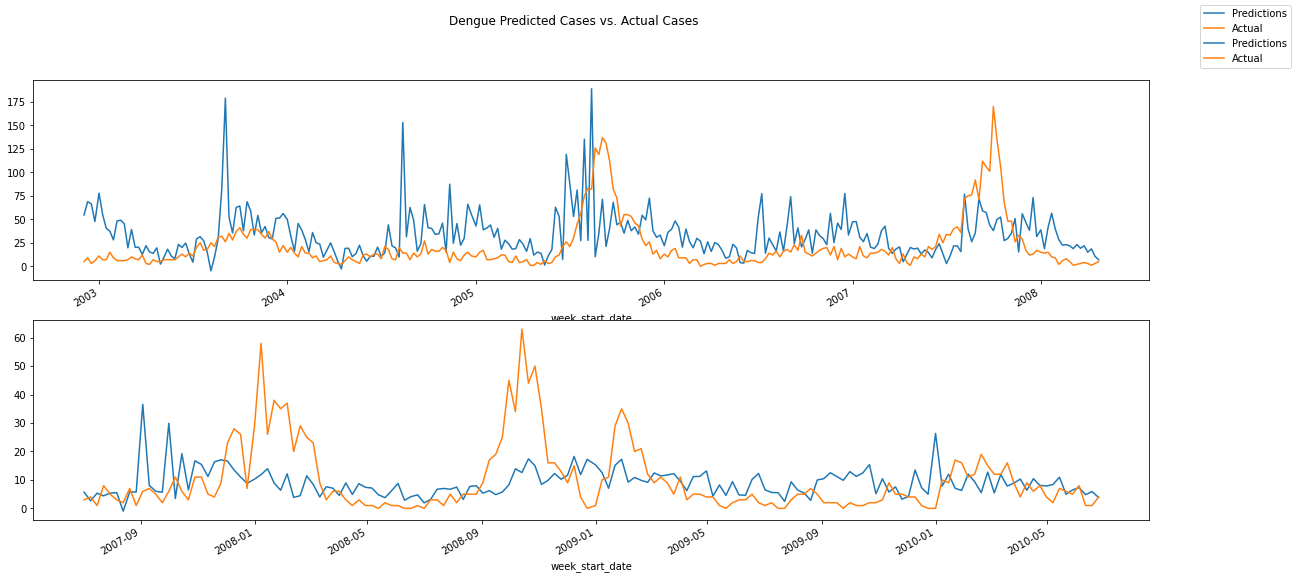

In [16]:
plt.rcParams["figure.figsize"] = (20,9)
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
sj_X_test['fitted'] = sj_rf.predict(sj_X_test)
sj_X_test.fitted.plot(ax=axes[0], label="Predictions")
sj_y_test.plot(ax=axes[0], label="Actual")

iq_X_test['fitted'] = iq_rf.predict(iq_X_test)
iq_X_test.fitted.plot(ax=axes[1], label="Predictions")
iq_y_test.plot(ax=axes[1], label="Actual")

figs.suptitle("Dengue Predicted Cases vs. Actual Cases")
figs.legend()

In [17]:
sj_X_test.drop('fitted',axis=1,inplace=True)
iq_X_test.drop('fitted',axis=1,inplace=True)

In [18]:
#submit data
sj_X_valid, iq_X_valid = get_data('dengue_features_test.csv',
                                    sj_tminus=sj_tminus,
                                    iq_tminus=iq_tminus,
                                    ) 

In [19]:
sj_X_valid

,weekofyear,ndvi_nw,ndvi_se,reanalysis_dew_point_temp_k,reanalysis_specific_humidity_g_per_kg,ndvi_nw_1,ndvi_se_1,reanalysis_dew_point_temp_k_1,reanalysis_specific_humidity_g_per_kg_1
week_start_date,,,,,,,,,
2008-04-29,18,-0.018900,0.102729,294.527143,15.918571,-0.080356,-0.080643,-0.936836,-0.937541
2008-05-06,19,-0.012400,0.082043,294.395714,15.791429,0.006500,-0.020686,-0.131429,-0.127143
2008-05-13,20,0.061357,0.151083,295.308571,16.674286,0.073757,0.069040,0.912857,0.882857
2008-05-20,21,-0.019867,0.124329,294.402857,15.775714,-0.081223,-0.026755,-0.905714,-0.898571
2008-05-27,22,0.039833,0.062267,294.760000,16.137143,0.059700,-0.062062,0.357143,0.361429
...,...,...,...,...,...,...,...,...,...
2013-03-26,13,-0.016183,0.156343,294.675714,15.985714,-0.022408,0.048829,3.688571,3.280000
2013-04-02,14,-0.077833,0.204171,294.628571,15.881429,-0.061650,0.047828,-0.047143,-0.104286
2013-04-09,15,-0.008200,0.192700,294.948571,16.212857,0.069633,-0.011471,0.320000,0.331429


In [20]:
iq_X_valid

,weekofyear,ndvi_nw,ndvi_sw,reanalysis_air_temp_k,reanalysis_dew_point_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,...,ndvi_sw_1,reanalysis_air_temp_k_1,reanalysis_dew_point_temp_k_1,reanalysis_precip_amt_kg_per_m2_1,reanalysis_specific_humidity_g_per_kg_1,reanalysis_tdtr_k_1,station_avg_temp_c_1,station_diur_temp_rng_c_1,station_min_temp_c_1,station_precip_mm_1
week_start_date,,,,,,,,,,,,,,,,,,,,,
2010-07-02,26,0.142500,0.150214,297.648571,296.118571,34.11,17.654286,9.428571,27.440,10.760,...,-0.127891,-1.406984,1.809212,-24.711818,1.814733,-0.709312,-0.186390,0.921957,2.20405,-2.145238
2010-07-09,27,0.272267,0.320914,298.224286,294.831429,9.10,16.320000,10.157143,27.025,9.625,...,0.170700,0.575714,-1.287143,-25.010000,-1.334286,0.728571,-0.415000,-1.135000,-0.30000,-2.300000
2010-07-16,28,0.366457,0.255514,297.955714,296.417143,61.09,18.030000,9.557143,26.950,10.350,...,-0.065400,-0.268571,1.585714,51.990000,1.710000,-0.600000,-0.075000,0.725000,0.40000,13.700000
2010-07-23,29,0.063214,0.081957,295.715714,293.638571,19.60,15.394286,7.828571,26.900,9.700,...,-0.173557,-2.240000,-2.778571,-41.490000,-2.635714,-1.728571,-0.050000,-0.650000,-7.40000,-17.800000
2010-07-30,30,0.327683,0.267914,298.502857,293.892857,18.93,15.468571,11.771429,27.050,11.850,...,0.185957,2.787143,0.254286,-0.670000,0.074286,3.942857,0.150000,2.150000,2.70000,-1.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-05-28,22,0.380029,0.383186,297.774286,295.638571,67.60,17.185714,10.100000,27.400,9.050,...,0.083757,0.894286,-0.211429,-56.600000,-0.197143,3.400000,0.766667,0.150000,0.00000,-64.300000
2013-06-04,23,0.296343,0.350357,297.167143,295.845714,45.70,17.448571,9.657143,27.520,10.720,...,-0.032829,-0.607143,0.207143,-21.900000,0.262857,-0.442857,0.120000,1.670000,-0.40000,35.000000
2013-06-11,24,0.251029,0.249771,295.831429,294.894286,45.22,16.410000,7.385714,27.200,10.075,...,-0.100586,-1.335714,-0.951429,-0.480000,-1.038571,-2.271429,-0.320000,-0.645000,0.20000,25.200000


In [21]:
b = sj_rf.predict(sj_X_valid).astype(int)
sj_predictions = sj_rf.predict(sj_X_valid).astype(int)
iq_predictions = iq_rf.predict(iq_X_valid).astype(int)

submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv("benchmark.csv")

/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [22]:
sj_predictions, iq_predictions

(array([ 18,  13,  17,  29,  22,  19,  14,  16,  12,  11,  12,  12,  18,
         16,  33,  24,   5, 115, 189,  26,  76,  75,  60,  45,  72,  71,
         55,  56,  38,  61,  22,  48,  63,  43,  40,  40,  52,  17,  44,
         33,  12,  24,  16,   9,  11,  11,  19,   2,   7,   8,  14,  13,
          8,   5,  20,  17,  17,  23,   6,  29,  16,   1,   3,  20,  23,
         15,  13,  23,  25,  38,  55,  47,  31,  66,  48,  47,  86,  22,
         13,  76,  27,  12,  45,  49,  27,  36,  38,  74,  50,  80,  41,
         59,  50,  26,  30,  54,  42,  39,  16,  19,  24,  34,   9,  16,
         20,  12,  13,  30,  14,  59,  63,  76, 121, 100,  93, 105,  29,
         58,  87, 179, 171,  74, 205,  57,  52,  25,  57,  53,  41,  27,
         17,  61,  71,  71,  34,  42,  36,  21,  14,  31,  33,  49,  43,
         29,  23,  19,  35,  10,  16,  43,  15,  10,  22,  20,  21,   3,
          8,  20,  32,  10,  17,  12,  10,  83, 125,  66,  92,  96,  17,
         69,  30, 222,  85, 185, 163,  35,  24,  40

In [23]:
print('sj', mean_absolute_error(sj_y_test, sj_rf.predict(sj_X_test)))
print('iq', mean_absolute_error(iq_y_test, iq_rf.predict(iq_X_test)))

sj 23.751561047343596
iq 8.029831529427797


/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


sj 17.274501779359433
iq 7.246260500628908

In [24]:
sj_X_test

,weekofyear,ndvi_nw,ndvi_se,reanalysis_dew_point_temp_k,reanalysis_specific_humidity_g_per_kg,ndvi_nw_1,ndvi_se_1,reanalysis_dew_point_temp_k_1,reanalysis_specific_humidity_g_per_kg_1
week_start_date,,,,,,,,,
2002-12-03,49,-0.120933,0.279086,295.205714,16.578571,-0.083683,0.001757,-0.887143,-0.931429
2002-12-10,50,-0.072300,0.199300,294.978571,16.327143,0.048633,-0.079786,-0.227143,-0.251429
2002-12-17,51,-0.128950,0.185414,294.577143,15.918571,-0.056650,-0.013886,-0.401429,-0.408571
2002-12-24,52,-0.252800,0.243433,294.805714,16.160000,-0.123850,0.058019,0.228571,0.241429
2003-01-01,1,-0.045250,0.230457,294.381429,15.845714,0.207550,-0.012976,-0.424286,-0.314286
...,...,...,...,...,...,...,...,...,...
2008-03-25,13,-0.039900,0.310471,292.095714,13.644286,-0.064350,0.208843,-0.110000,-0.092857
2008-04-01,14,-0.016833,0.119371,293.235714,14.662857,0.023067,-0.191100,1.140000,1.018571
2008-04-08,15,-0.052750,0.137757,292.732857,14.184286,-0.035917,0.018386,-0.502857,-0.478571


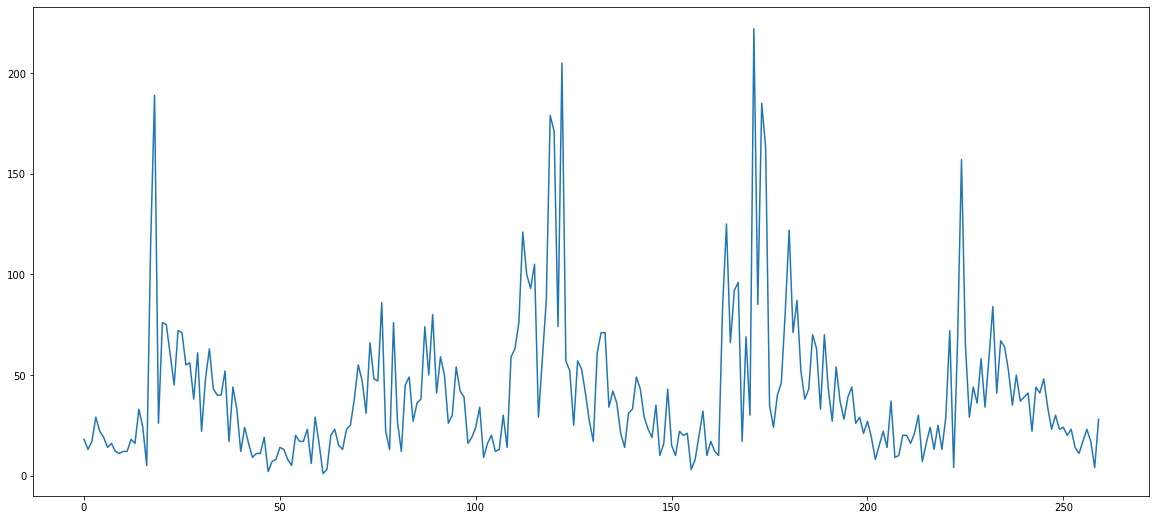

In [25]:
plt.plot(sj_predictions)

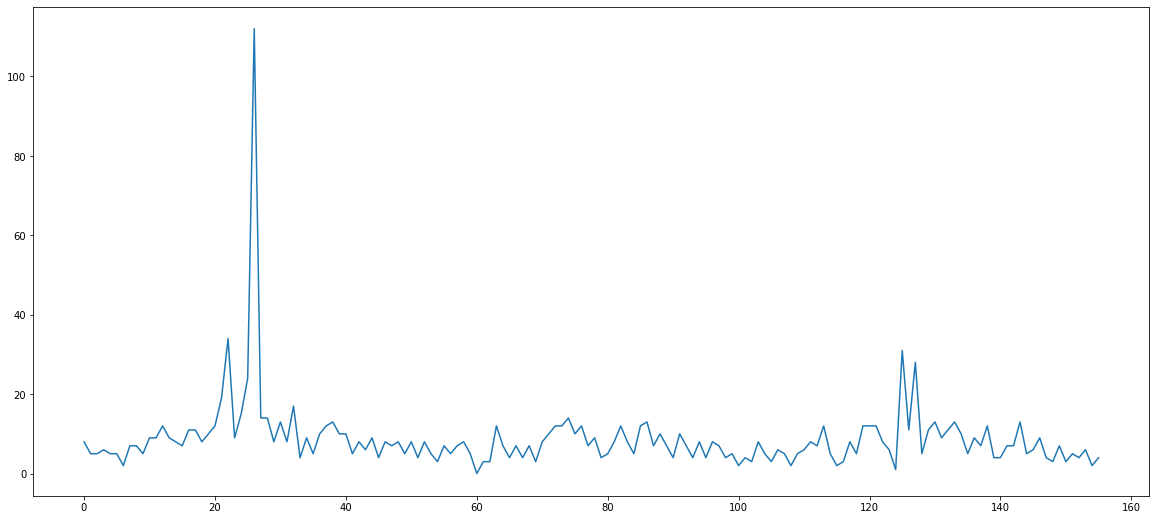

In [26]:
plt.plot(iq_predictions)

<AxesSubplot:xlabel='week_start_date'>

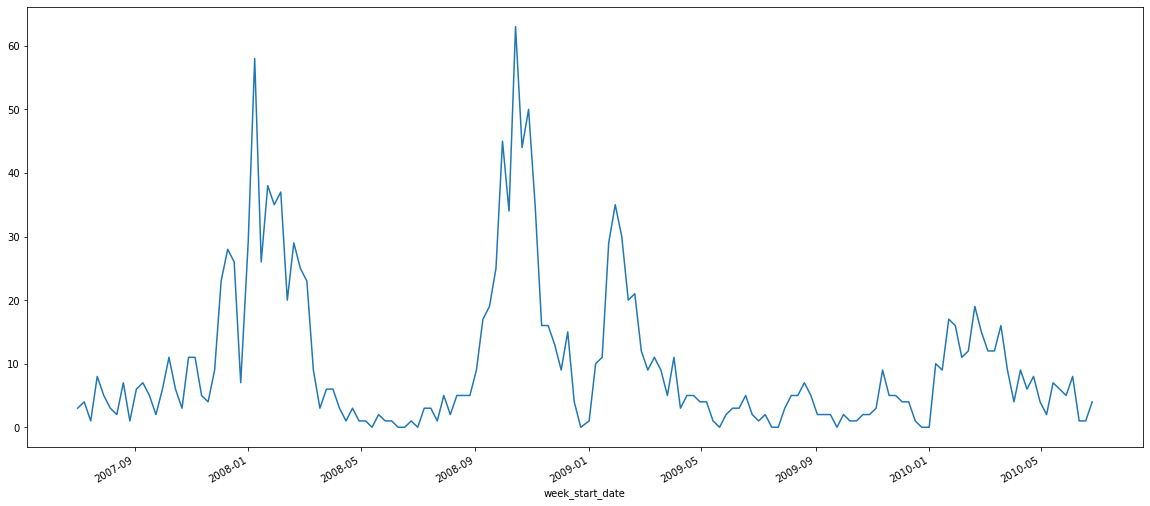

In [27]:
iq_y_test.plot()